In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import matplotlib.image as mpimg
from matplotlib import cm
import matplotlib.animation as ani
from scipy.integrate import odeint
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import pearsonr

import seaborn as sns
import copy

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
def plot_map(lat, long, para):
    amin = np.amin(para)
    amax = np.amax(para)
    matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
    fig = plt.figure()
    plt.pcolor(long, lat, para, cmap='seismic', vmin=max(abs(amin), abs(amax)), vmax=(-1)*max(abs(amin), abs(amax)))
    plt.tight_layout()
    cbar = plt.colorbar()

In [3]:
isotopes = Dataset('climatology/xnapa_isotopes.nc', "a")
precipitation = Dataset('climatology/xnapa_precip.nc', "a")
surface_temperature = Dataset('climatology/xnapa_temp.nc', "a")

In [4]:
lat = isotopes.variables["latitude"][:].data[1:-1]
long = isotopes.variables["longitude"][:].data
t = isotopes.variables["t"][:].data

trash = [626, 0]

In [5]:
do18 = []
precip = []
temp = []
for i in range(len(t)):
    do18.append(isotopes.variables["dO18"][i][0].data[1:-1].reshape(71*96))
    precip.append(precipitation.variables["precip"][i][0].data[1:-1].reshape(71*96))
    temp.append(surface_temperature.variables["temp_1"][i][0].data[1:-1].reshape(71*96))
    
do18 = pd.DataFrame(np.delete(np.delete(np.asarray(do18), 0, 0), 626, 0)[:1000])
precip = pd.DataFrame(np.delete(np.delete(np.asarray(precip), 0, 0), 626, 0)[:1000])
temp = pd.DataFrame(np.delete(np.delete(np.asarray(temp), 0, 0), 626, 0)[:1000])

In [41]:
n_temp = 20
n_precip = 20
n_y = 20

In [42]:
scaler_temp = StandardScaler().fit(temp)
scaler_precip = StandardScaler().fit(precip)
scaler_do18 = StandardScaler().fit(do18)

do18_scaler = scaler_do18.transform(do18)
temp_scaler = scaler_temp.transform(temp)
precip_scaler = scaler_precip.transform(precip)

In [43]:
pca_temp = PCA(n_components=n_temp).fit(temp_scaler)
pca_precip = PCA(n_components=n_precip).fit(precip_scaler)
pca_do18 = PCA(n_components=n_y).fit(do18_scaler)

In [44]:
do18_pc = pd.DataFrame(pca_do18.transform(do18_scaler)).rename(columns=lambda s: "d18O "+str(s))
temp_pc = pd.DataFrame(pca_temp.transform(temp_scaler)).rename(columns=lambda s: "temperature "+str(s))
precip_pc = pd.DataFrame(pca_precip.transform(precip_scaler)).rename(columns=lambda s: "precipitation "+str(s))
data = pd.concat([temp_pc, precip_pc, do18_pc], axis=1)
variables = data.columns.values

In [45]:
data

,temperature 0,temperature 1,temperature 2,temperature 3,temperature 4,temperature 5,temperature 6,temperature 7,temperature 8,temperature 9,...,d18O 10,d18O 11,d18O 12,d18O 13,d18O 14,d18O 15,d18O 16,d18O 17,d18O 18,d18O 19
0,1.009458,-3.288708,-8.010860,21.946261,-9.907983,-11.273128,-0.577059,-7.518702,-5.316746,12.393254,...,15.500628,16.199258,-2.839833,-4.162143,11.825476,7.272433,-19.009104,0.203959,0.036178,3.410909
1,27.299223,-0.485221,-4.097841,3.957848,2.665323,-21.374710,-11.721844,-9.964386,0.520232,15.598377,...,5.239604,10.470407,5.036048,1.183154,6.728308,-8.842515,0.627229,1.396634,-0.325068,5.422644
2,10.586073,28.154716,-3.305150,-21.258606,6.022424,-0.745564,-8.730142,-1.519862,7.064494,19.744135,...,9.441765,0.903058,6.801564,-9.651285,4.188692,10.460096,-3.853898,7.901323,4.106987,3.106639
3,1.663390,2.728838,-22.506586,9.672727,11.818119,-0.332024,-22.559553,18.061860,5.732317,10.468403,...,-9.213699,-5.870888,14.897885,-12.516355,4.946864,7.066225,7.829695,-4.590082,-3.934832,-11.267640
4,7.358112,2.979872,9.515022,-20.229673,-9.611160,-2.902971,8.650887,3.877586,4.934326,2.120940,...,0.973738,3.002956,-0.191296,1.461873,-6.827046,-4.519277,11.301897,-0.198247,-1.409353,1.511068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-20.604240,-9.552785,10.092242,-4.588730,-11.739966,10.973676,-15.715568,-10.076644,-9.915665,5.453191,...,0.436182,11.609461,4.143546,5.043142,7.006554,-2.243187,-1.436386,4.659490,4.203077,-4.025173
996,21.776027,-24.222852,12.048207,-22.825695,-1.640352,4.547383,-21.068236,-6.172373,13.468438,-2.129430,...,-4.762737,1.963164,-5.630328,5.856043,-9.591315,-8.408571,4.297462,-8.898242,10.502285,5.919716
997,5.248151,-10.373183,24.503602,-36.950778,-20.579731,7.744939,-10.515080,-22.807254,-9.623760,-1.174414,...,-7.461032,10.254777,1.906530,4.693891,-6.357299,7.821688,-1.770392,14.118446,5.556198,-7.057476
998,-20.379671,-29.787540,11.450182,14.157735,-22.839062,-3.376061,2.347845,-16.772137,-27.202485,-17.847580,...,-10.016218,-5.957949,1.213489,8.561122,-19.423351,-1.081601,5.800186,5.888975,8.810493,-13.922855


# Covariance matrix

In [46]:
cov_matrix = pd.DataFrame(np.cov(data.transpose()))

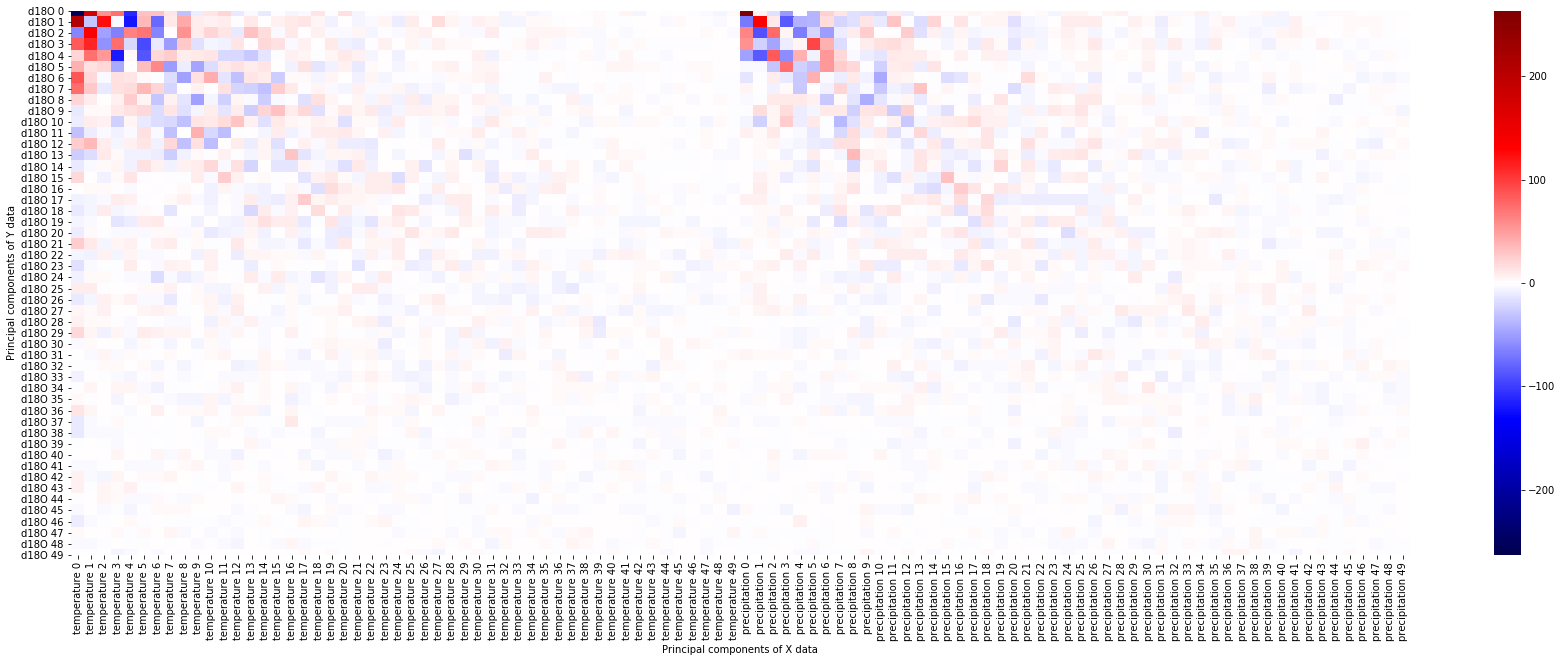

In [19]:
plt.figure(figsize=(30,10))

cov_matrix2 = cov_matrix.loc[n_temp+n_precip:, :n_temp+n_precip-1]
cov_matrix2.index = variables[n_temp+n_precip:]
cov_matrix2.columns = variables[:n_temp+n_precip]

cmax = abs(cov_matrix2.max().max())
cmin = abs(cov_matrix2.min().min())

sns.heatmap(cov_matrix2, 
        cmap="seismic",
        vmin=(-1)*max(cmax,cmin),
        vmax=max(cmax,cmin),
        xticklabels=cov_matrix2.columns,
        yticklabels=cov_matrix2.index)

plt.xlabel("Principal components of X data")
plt.ylabel("Principal components of Y data")
plt.show()

# Pearson correlation matrix

In [47]:
corr = data.corr(method="pearson")

In [48]:
corr2 = pd.DataFrame(corr.values[n_temp+n_precip:, :n_temp+n_precip])
corr2.index = variables[n_temp+n_precip:]
corr2.columns = variables[:n_temp+n_precip]

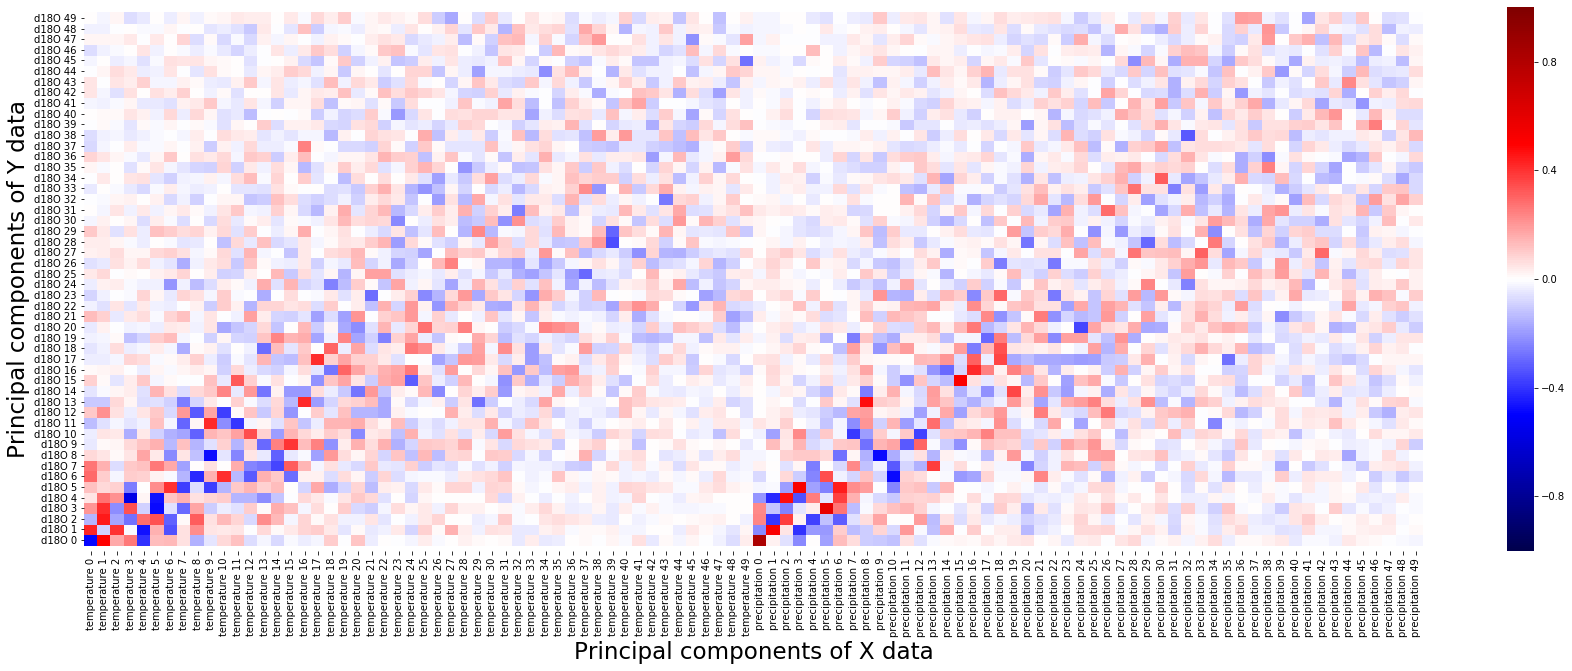

In [22]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'figure.autolayout': True})

sns.heatmap(corr2, 
        cmap="seismic",
        vmin=1,
        vmax=-1,
        xticklabels=corr2.columns,
        yticklabels=corr2.index)

plt.xlabel("Principal components of X data", fontsize=23)
plt.ylim(-0.5,50.5)
plt.ylabel("Principal components of Y data", fontsize=23)
#plt.savefig("figures/pearson.png")
plt.show()

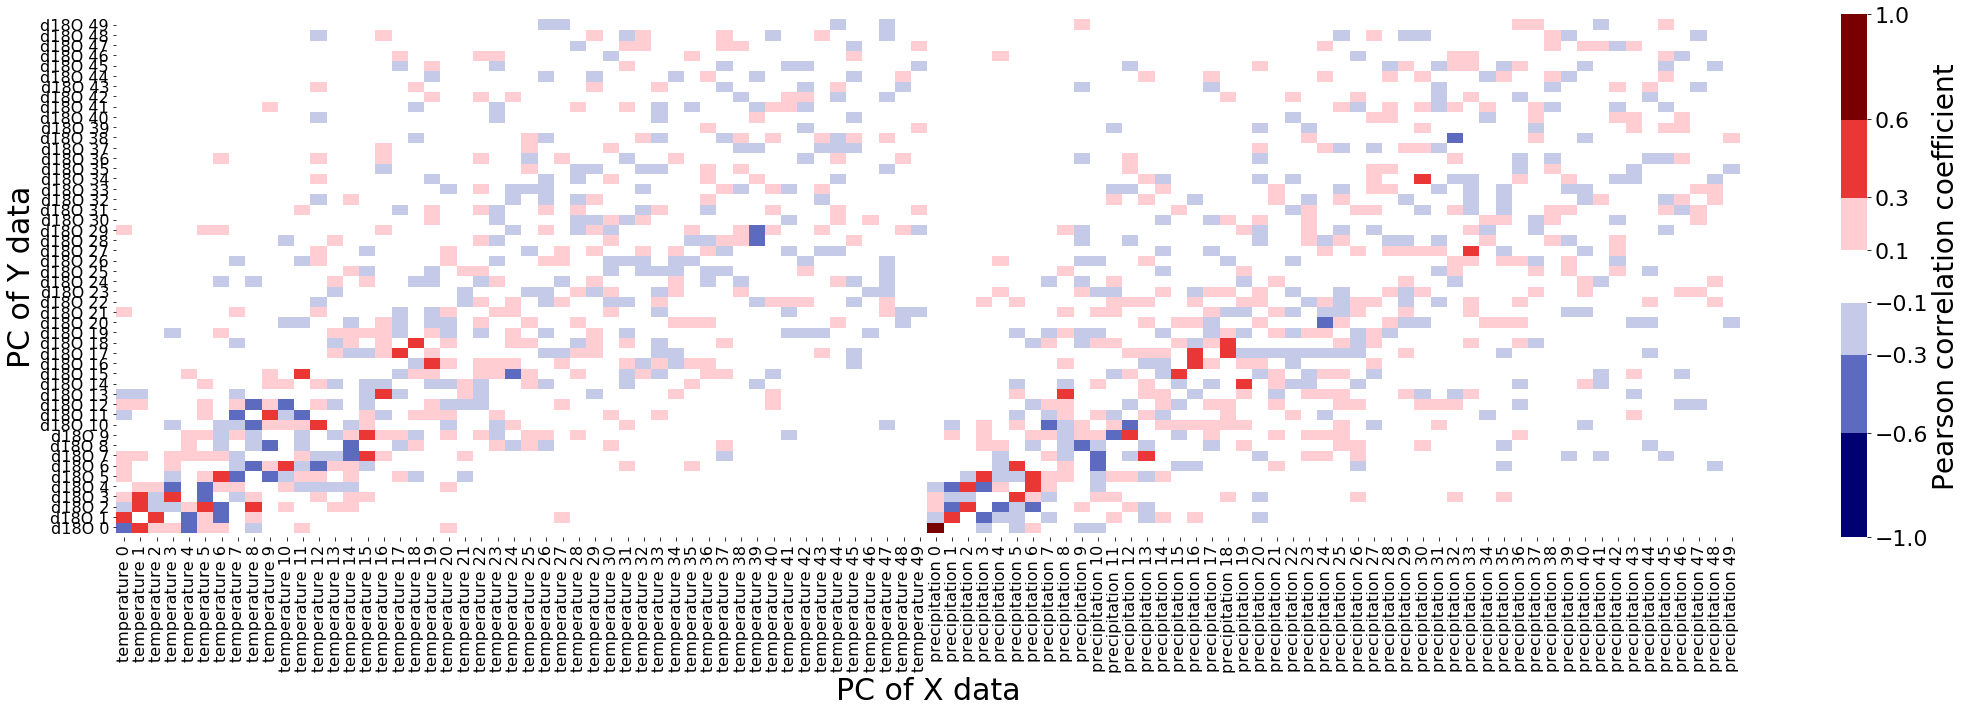

In [40]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'figure.autolayout': True})

colors = ["#000072","#5c6bc0", "#c5cae9", "#ffffff", "#ffcdd2", "#eb3636", "#780000"]

bounds = [-1, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 1] 
cmap= matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

ax = sns.heatmap(corr2, 
        cmap=cmap,
        vmin=-1,
        vmax=1,
        xticklabels=corr2.columns,
        yticklabels=corr2.index,
        cbar=True,
        norm=norm,
        cbar_kws={
            "ticks":bounds, 
            "spacing": "proportional", 
            "norm": norm,
            "label": "Pearson correlation coefficient"
        }
)
ax.tick_params(labelsize=16)

plt.xlabel("PC of X data", fontsize=30)
plt.ylim(-0.5,50.5)
plt.ylabel("PC of Y data", fontsize=30)

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=22)
ax.figure.axes[-1].yaxis.label.set_size(28)


#plt.savefig("figures/pearson50.png", bbox_inches="tight")
plt.show()

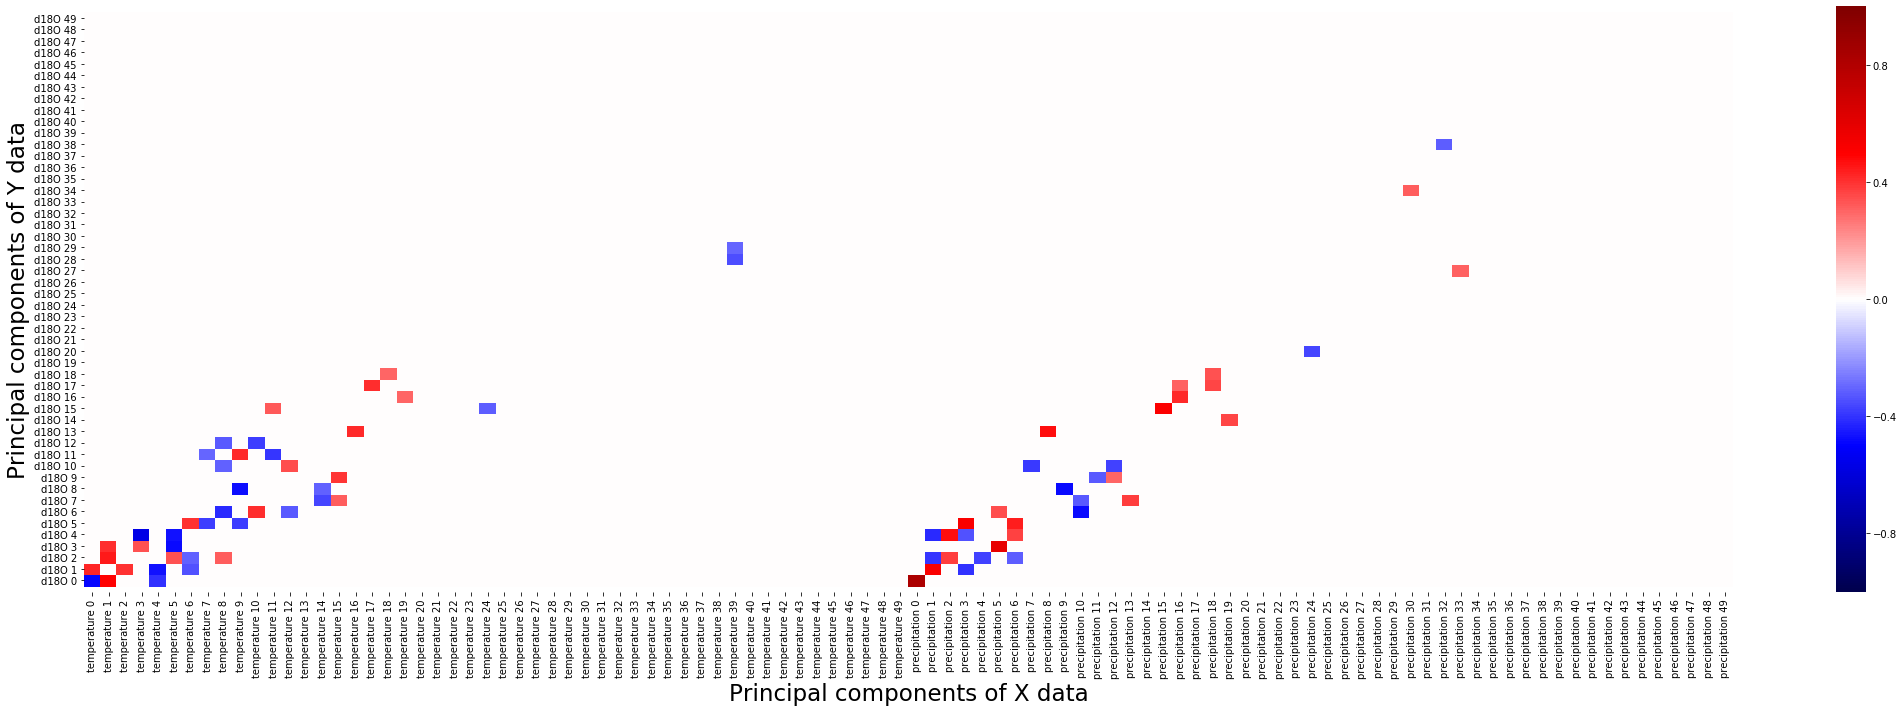

In [85]:
corr3 = copy.deepcopy(corr2)
threshold = 0.3
for c in corr3.columns:
    corr3.loc[(corr3[c] > -threshold) & (corr3[c] < threshold), c] = 0
    
plt.figure(figsize=(30,10))

sns.heatmap(corr3, 
        cmap="seismic",
        vmin=1,
        vmax=-1,
        xticklabels=corr3.columns,
        yticklabels=corr3.index)

plt.ylim(-0.5,50.5)
plt.xlabel("Principal components of X data", fontsize=23)
plt.ylabel("Principal components of Y data", fontsize=23)
plt.show()

# p-values

In [49]:
p_matrix = []
for y in range(n_temp+n_precip, n_temp+n_precip+n_y):
    p_y = []
    for x in range(0, n_temp+n_precip):
        p_y.append(pearsonr(data.values[:,y], data.values[:,x])[1])
    p_matrix.append(p_y)
p_matrix = pd.DataFrame(np.array(p_matrix))
p_matrix.index = variables[n_temp+n_precip:]
p_matrix.columns = variables[:n_temp+n_precip]

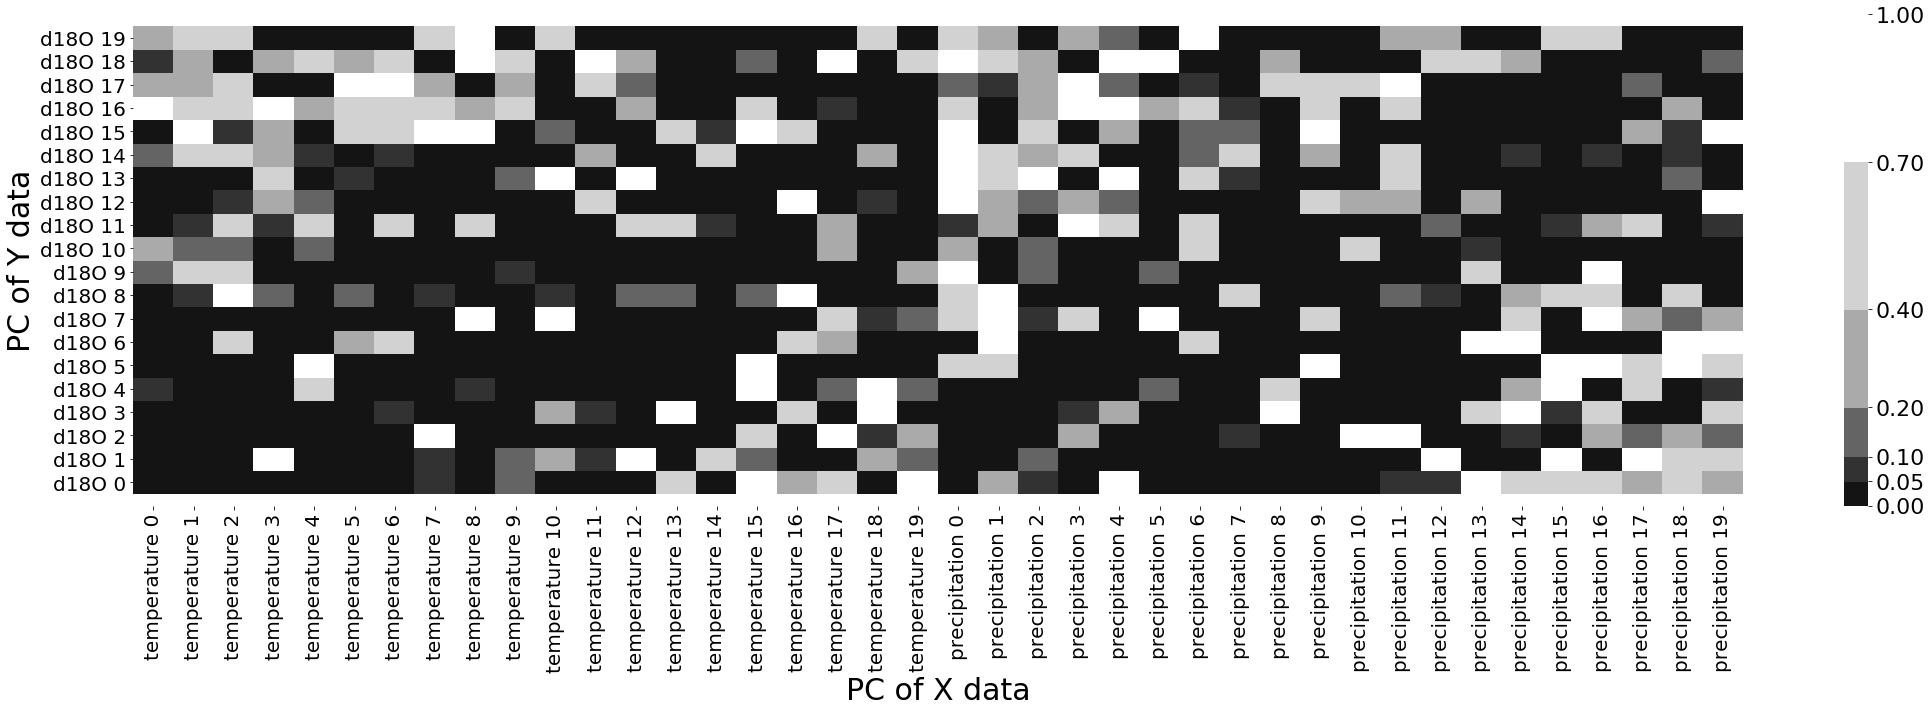

In [68]:
plt.figure(figsize=(30,10))

colors = ["#141414","#323232", "#646464", "#aaaaaa", "#d2d2d2", "#ffffff"]

bounds = [0, 0.05, 0.1, 0.2, 0.4, 0.7, 1] 
cmap= matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


sns.heatmap(p_matrix, 
        cmap=cmap,
        vmin=0,
        vmax=1,
        xticklabels=p_matrix.columns,
        yticklabels=p_matrix.index,
        cbar=True,
        norm=norm,
        cbar_kws={
            "ticks":bounds, 
            "spacing": "proportional", 
            "norm": norm,
        }
)
ax.tick_params(labelsize=16)
plt.ylim(-0.5,20.5)
plt.xlabel("PC of X data", fontsize=30)
plt.ylabel("PC of Y data", fontsize=30)

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=22)
ax.figure.axes[-1].yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig("figures/pvalues.png")
plt.show()

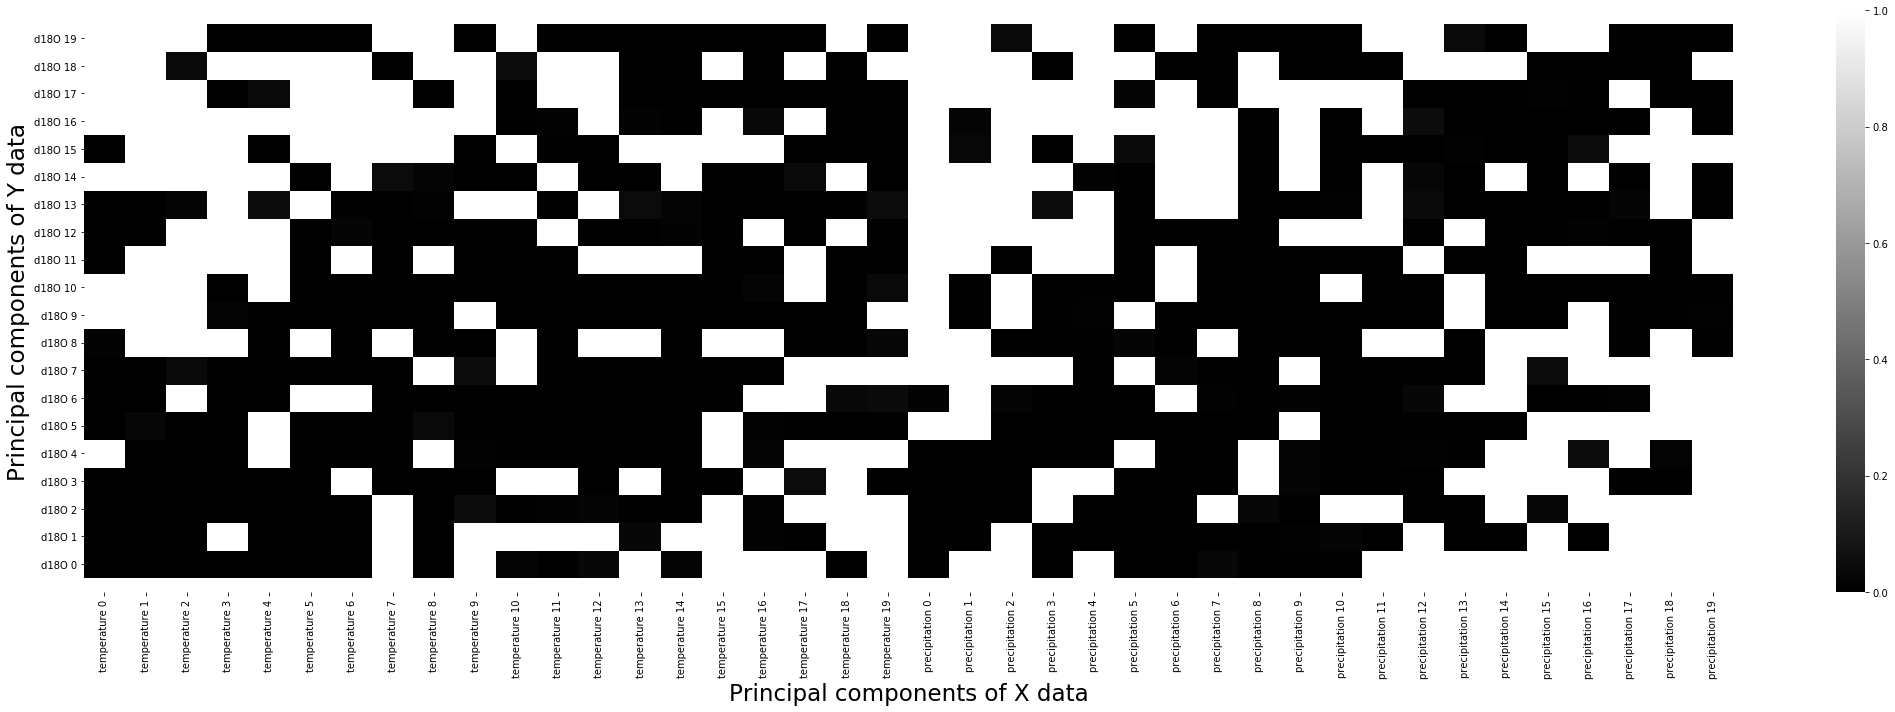

In [69]:
p_matrix2 = copy.deepcopy(p_matrix)
threshold = 0.05
for c in p_matrix2.columns:
    p_matrix2.loc[p_matrix2[c] > threshold, c] = 1
    
plt.figure(figsize=(30,10))

sns.heatmap(p_matrix2, 
        cmap="gist_gray",
        vmin=0,
        vmax=1,
        xticklabels=p_matrix2.columns,
        yticklabels=p_matrix2.index)

plt.ylim(-0.5,20.5)
plt.xlabel("Principal components of X data", fontsize=23)
plt.ylabel("Principal components of Y data", fontsize=23)
plt.show()

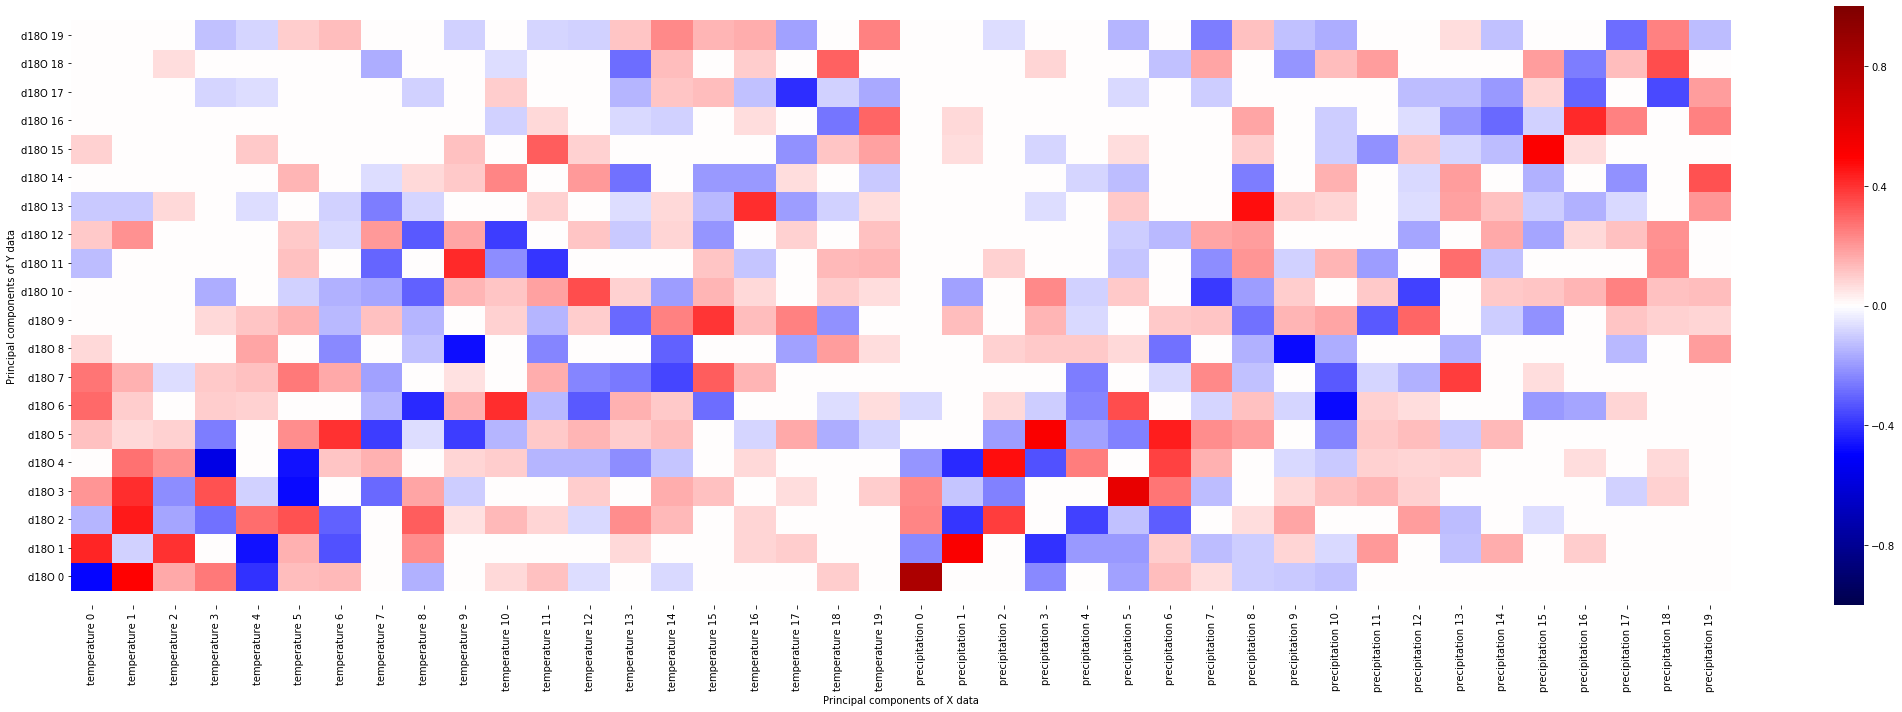

In [70]:
corr4 = copy.deepcopy(corr2)
for r in range(n_y):
    for c in range(n_temp+n_precip):
        if p_matrix2.values[r, c] == 1.0:
            corr4.loc[corr4.index[r], corr4.columns[c]] = 0
    
plt.figure(figsize=(30,10))

sns.heatmap(corr4, 
        cmap="seismic",
        vmin=1,
        vmax=-1,
        xticklabels=corr4.columns,
        yticklabels=corr4.index)

plt.ylim(-0.5,20.5)

plt.xlabel("Principal components of X data")
plt.ylabel("Principal components of Y data")
plt.show()

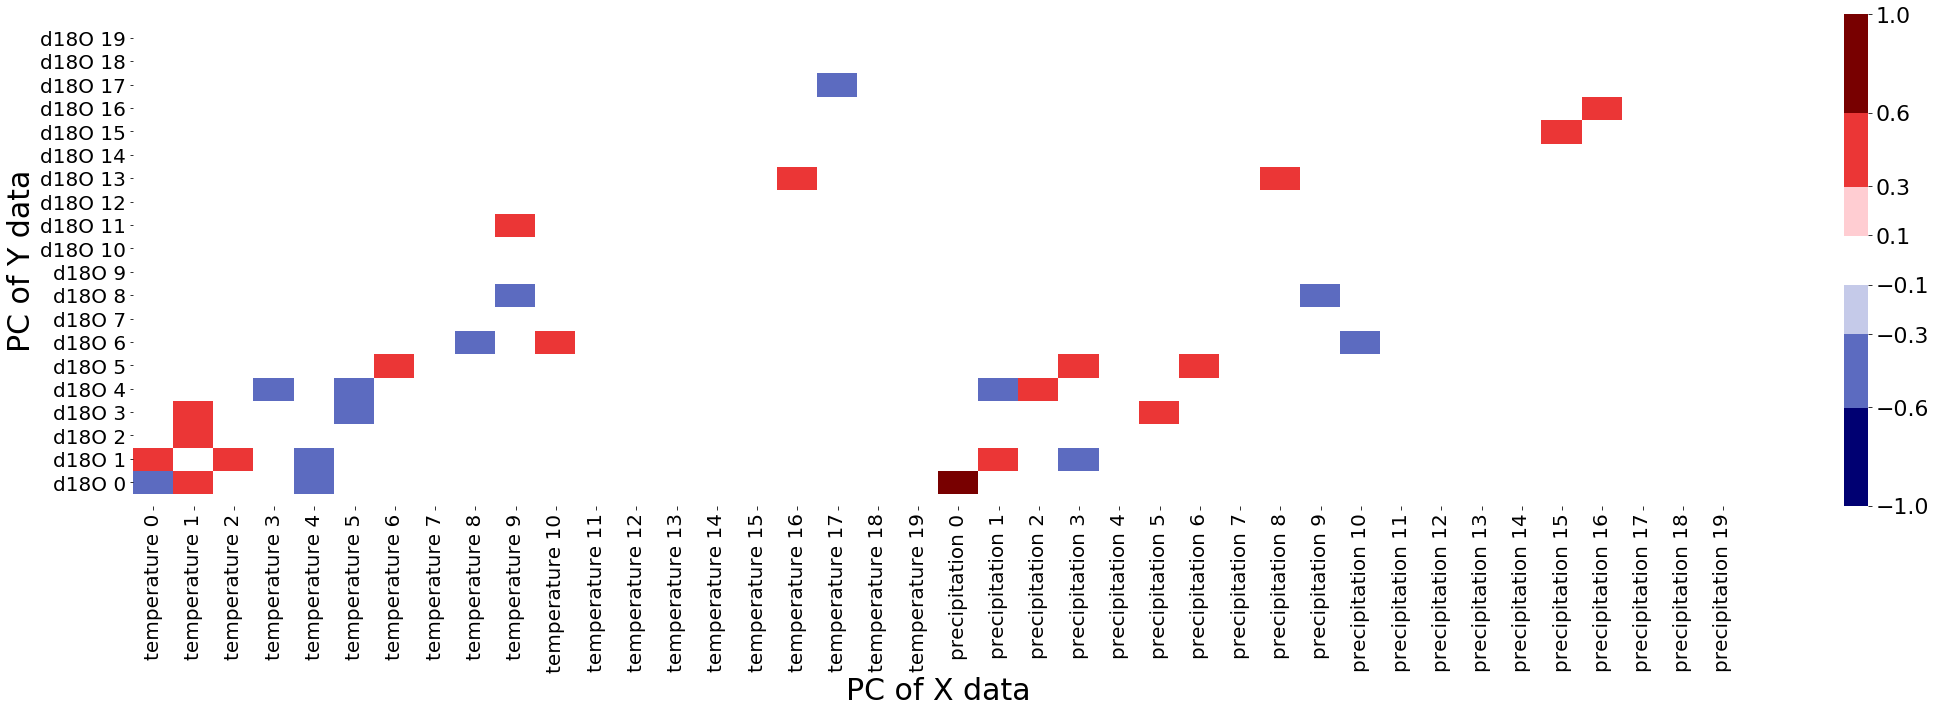

In [77]:
corr5 = copy.deepcopy(corr4)
threshold = 0.4
for c in corr5.columns:
    corr5.loc[(corr5[c] > -threshold) & (corr5[c] < threshold), c] = 0
    
plt.figure(figsize=(30,10))

colors = ["#000072","#5c6bc0", "#c5cae9", "#ffffff", "#ffcdd2", "#eb3636", "#780000"]

bounds = [-1, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 1] 
cmap= matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

sns.heatmap(corr5, 
        cmap=cmap,
        vmin=-1,
        vmax=1,
        xticklabels=corr5.columns,
        yticklabels=corr5.index,
        cbar=True,
        norm=norm,
        cbar_kws={
            "ticks":bounds, 
            "spacing": "proportional", 
            "norm": norm,
        }
)
plt.ylim(-0.5,20.5)
ax.tick_params(labelsize=16)

plt.xlabel("PC of X data", fontsize=30)
plt.ylabel("PC of Y data", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=22)
ax.figure.axes[-1].yaxis.label.set_size(28)
#plt.savefig("figures/corr{}.png".format(threshold))
plt.show()

# Autocorrelation

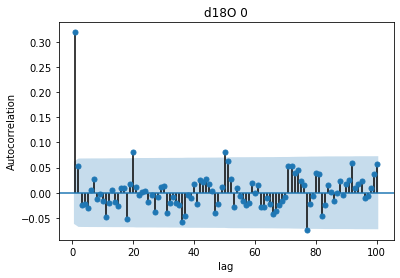

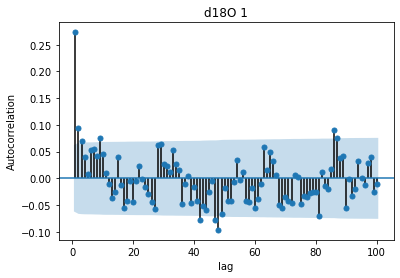

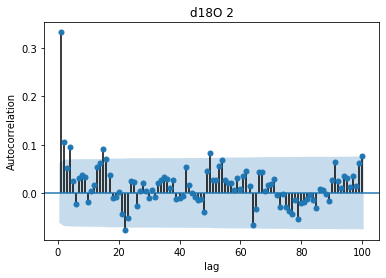

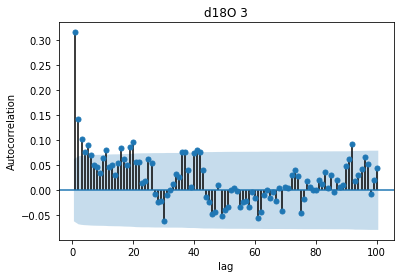

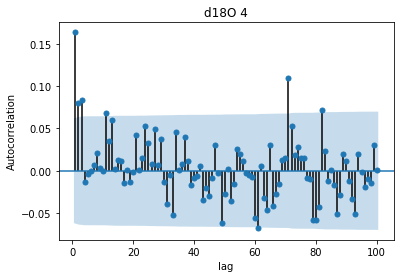

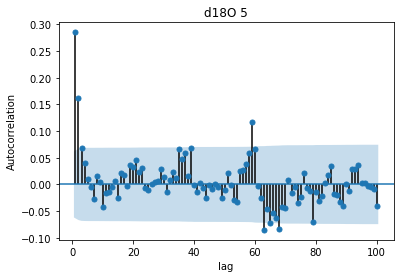

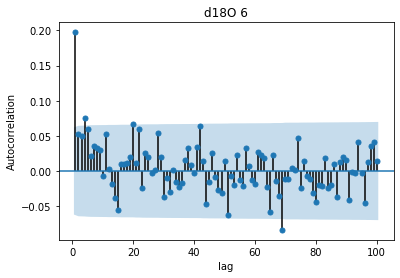

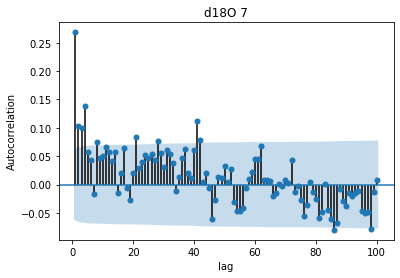

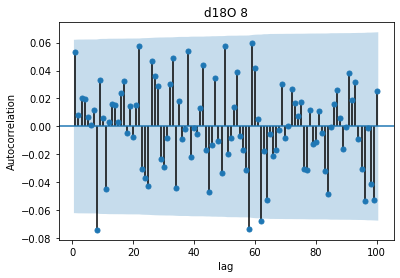

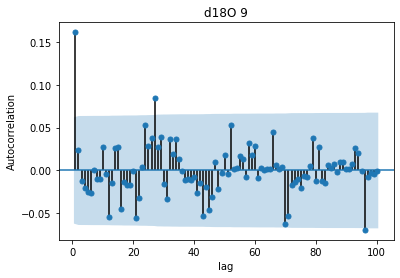

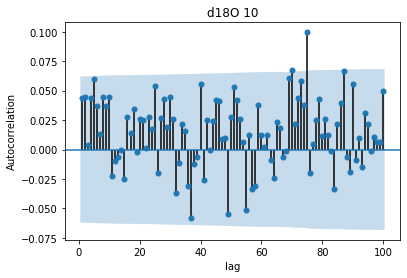

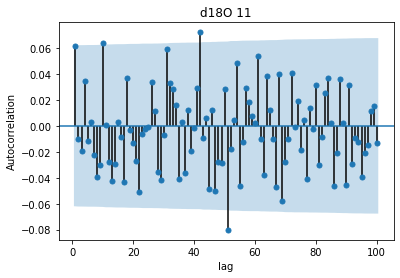

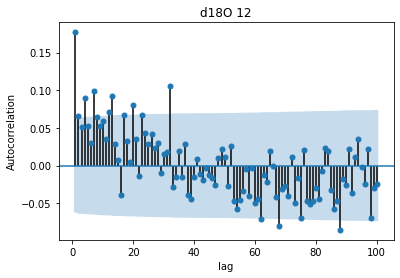

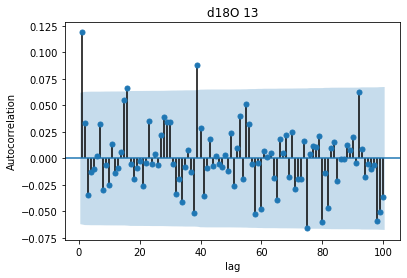

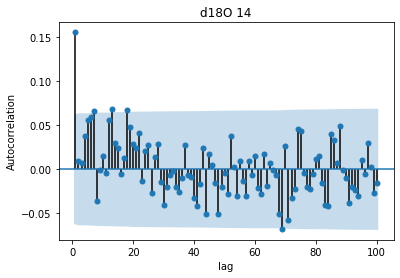

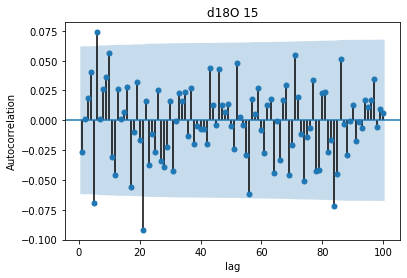

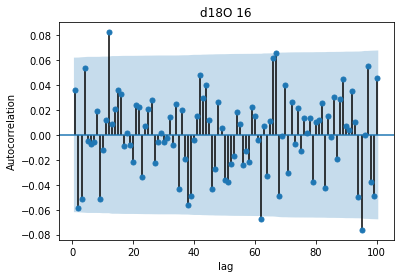

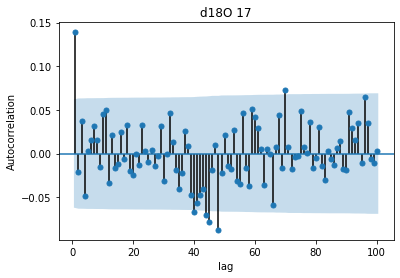

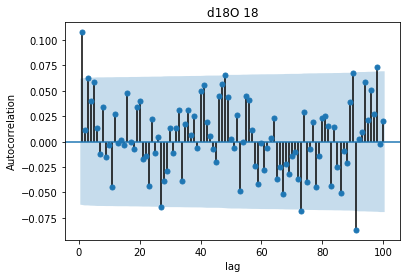

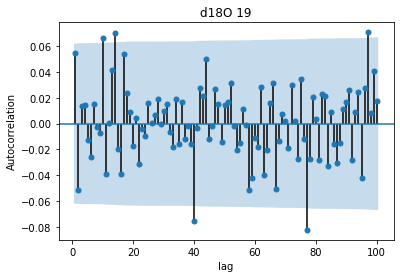

In [174]:
for i in range(0, len(do18_pc.values[0])):
    plot_acf(do18_pc.values[:,i], lags=100, title=do18_pc.columns[i], zero=False, alpha=0.05)
    plt.xlabel("lag")
    plt.ylabel("Autocorrelation")
    plt.show()

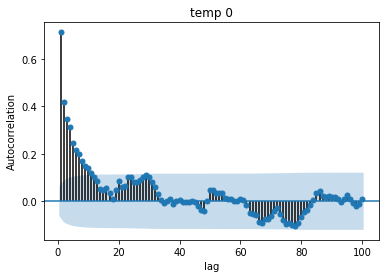

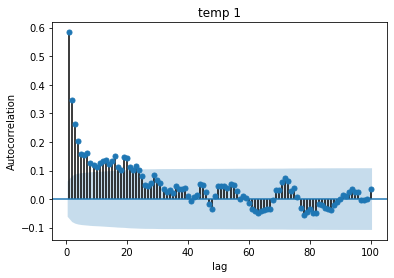

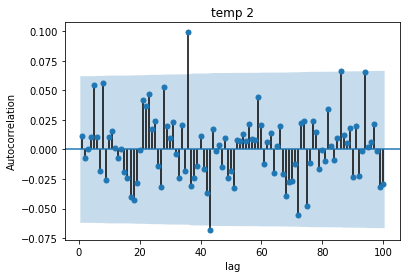

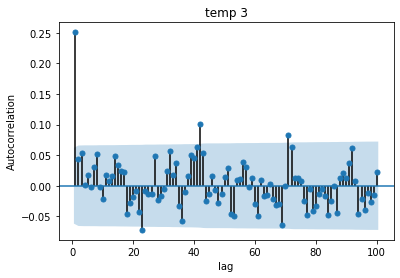

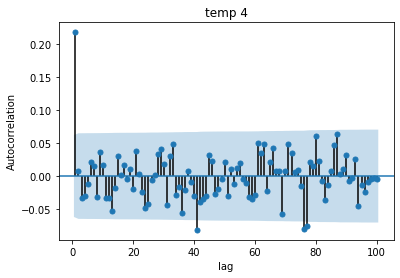

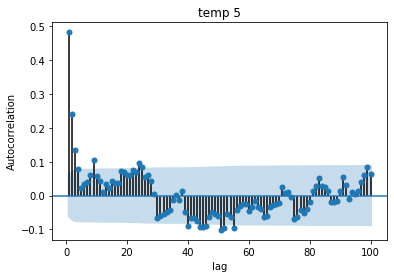

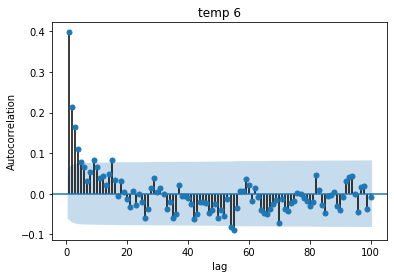

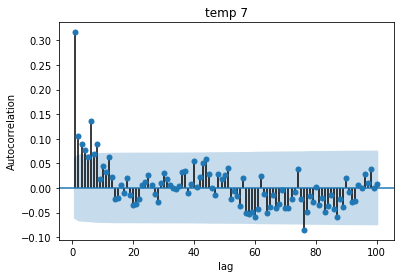

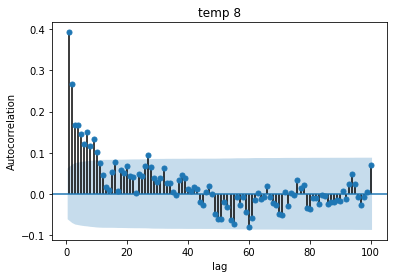

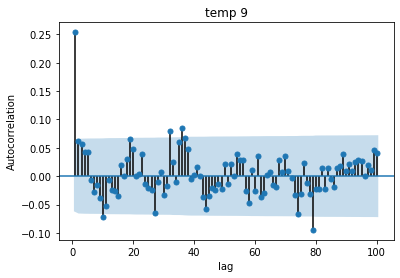

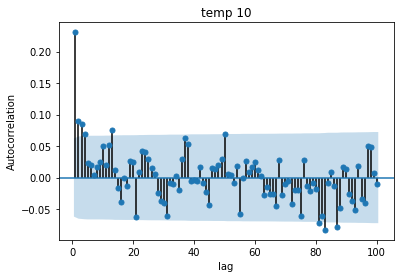

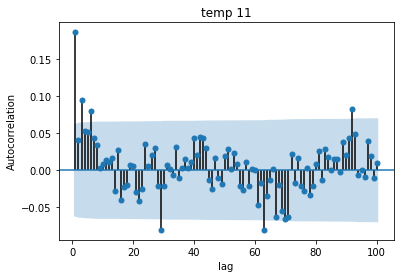

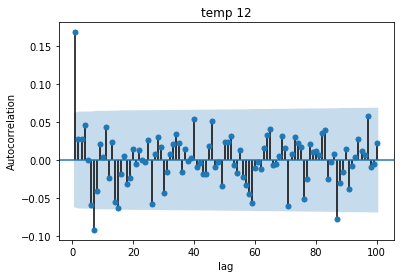

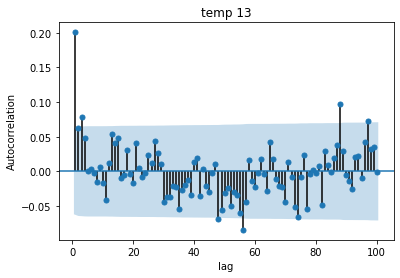

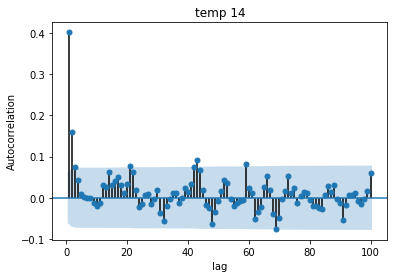

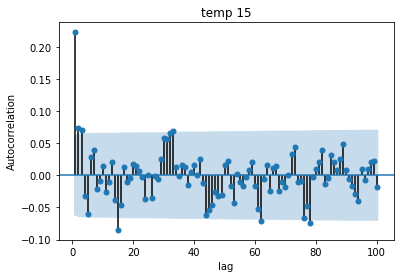

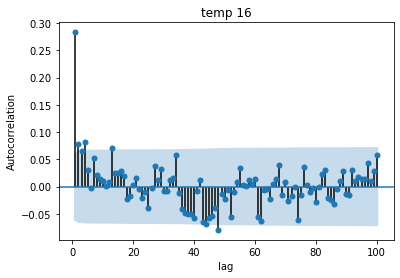

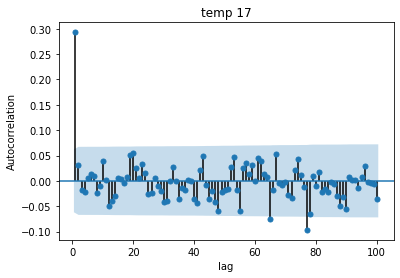

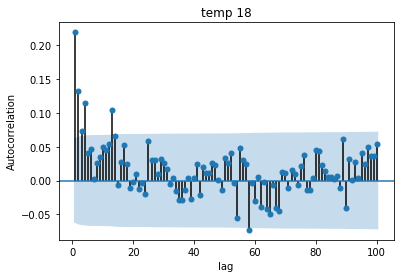

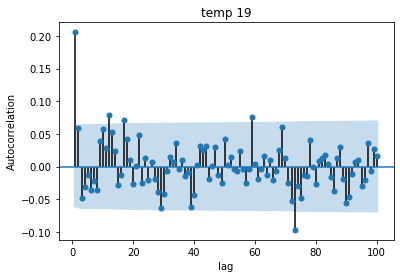

In [62]:
for i in range(0, len(temp_pc.values[0])):
    plot_acf(temp_pc.values[:,i], lags=100, title=temp_pc.columns[i], zero=False, alpha=0.05)
    plt.xlabel("lag")
    plt.ylabel("Autocorrelation")
    plt.show()

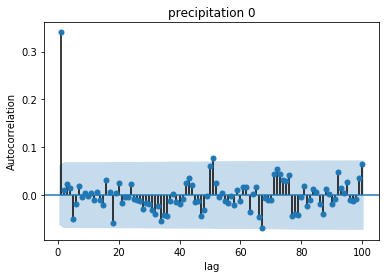

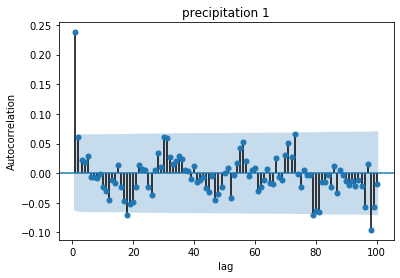

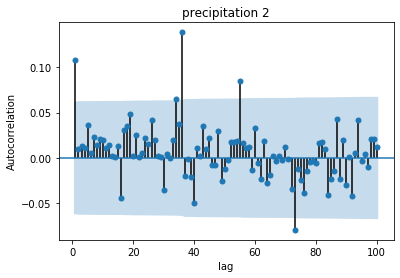

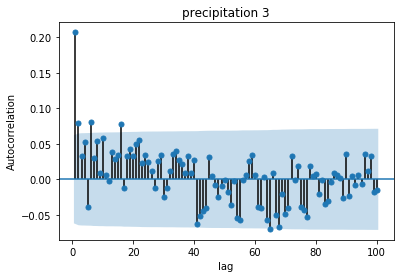

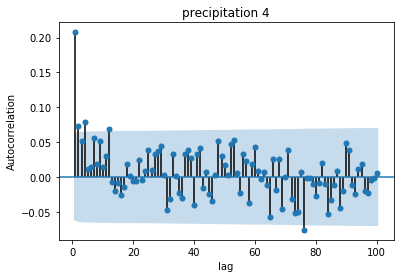

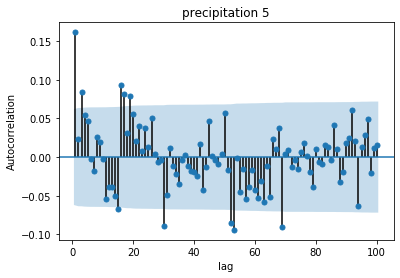

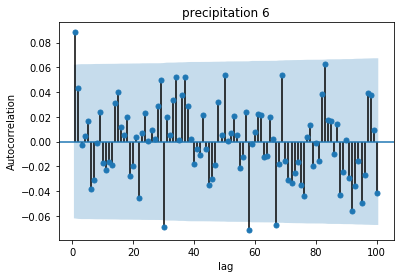

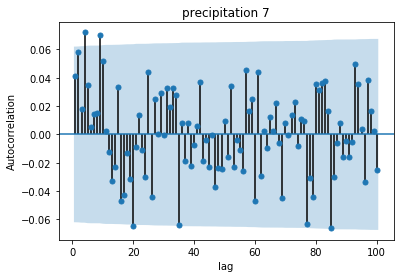

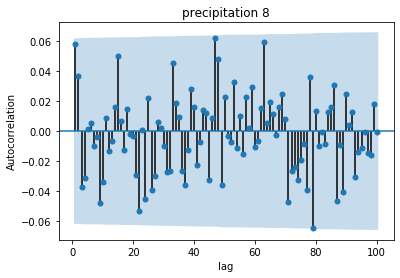

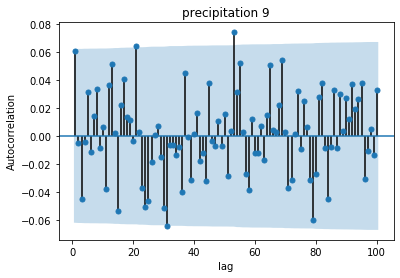

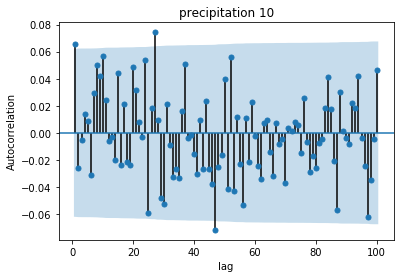

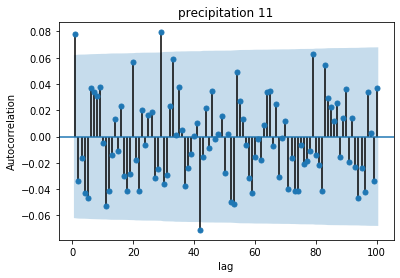

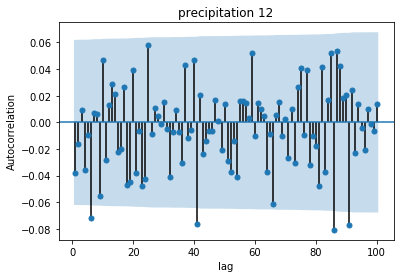

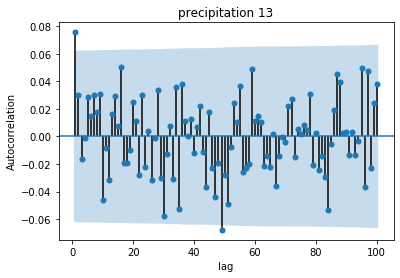

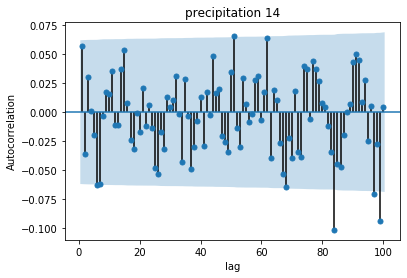

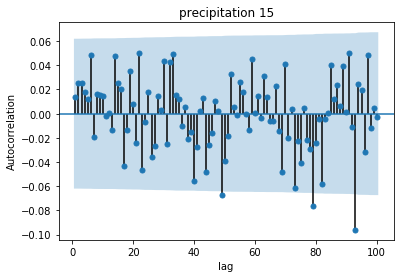

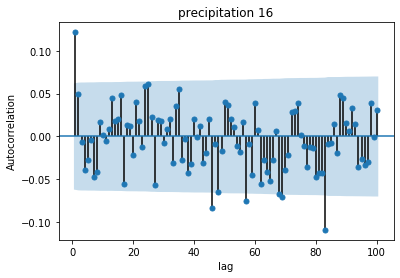

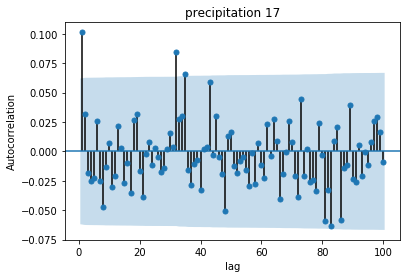

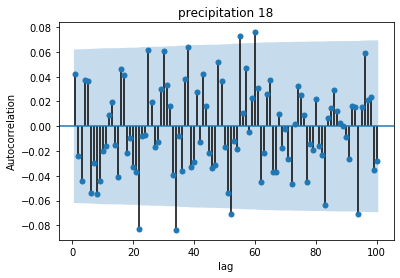

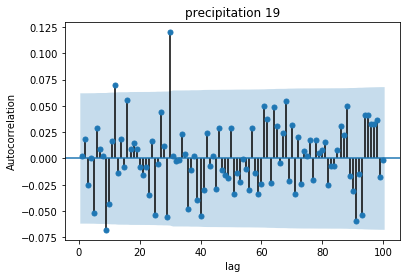

In [171]:
for i in range(0, len(precip_pc.values[0])):
    plot_acf(precip_pc.values[:,i], lags=100, title=precip_pc.columns[i], zero=False, alpha=0.05)
    plt.xlabel("lag")
    plt.ylabel("Autocorrelation")
    plt.show()